In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
from __future__ import print_function
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from preprocess import *
from utils import *

In [2]:
crop_size = (256, 256)

def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], crop_size[0], crop_size[1], 3))
        for i in range(batch.shape[0]):
            batch_crops[i] = crop_img(batch[i], crop_size)
            batch_crops[i] = (batch_crops[i] - 0.5) * 2 # shift to -1,1
        yield batch_crops, batch_crops


downscale_fact = 2
image_height_orig = 720
image_width_orig = 1280
image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

train_ds, test_ds = create_dataflows('../images', (image_height_ds, image_width_ds), 32)

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

# train_ds_mapped = pair_mapping(train_ds)
# test_ds_mapped = pair_mapping(test_ds)



Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


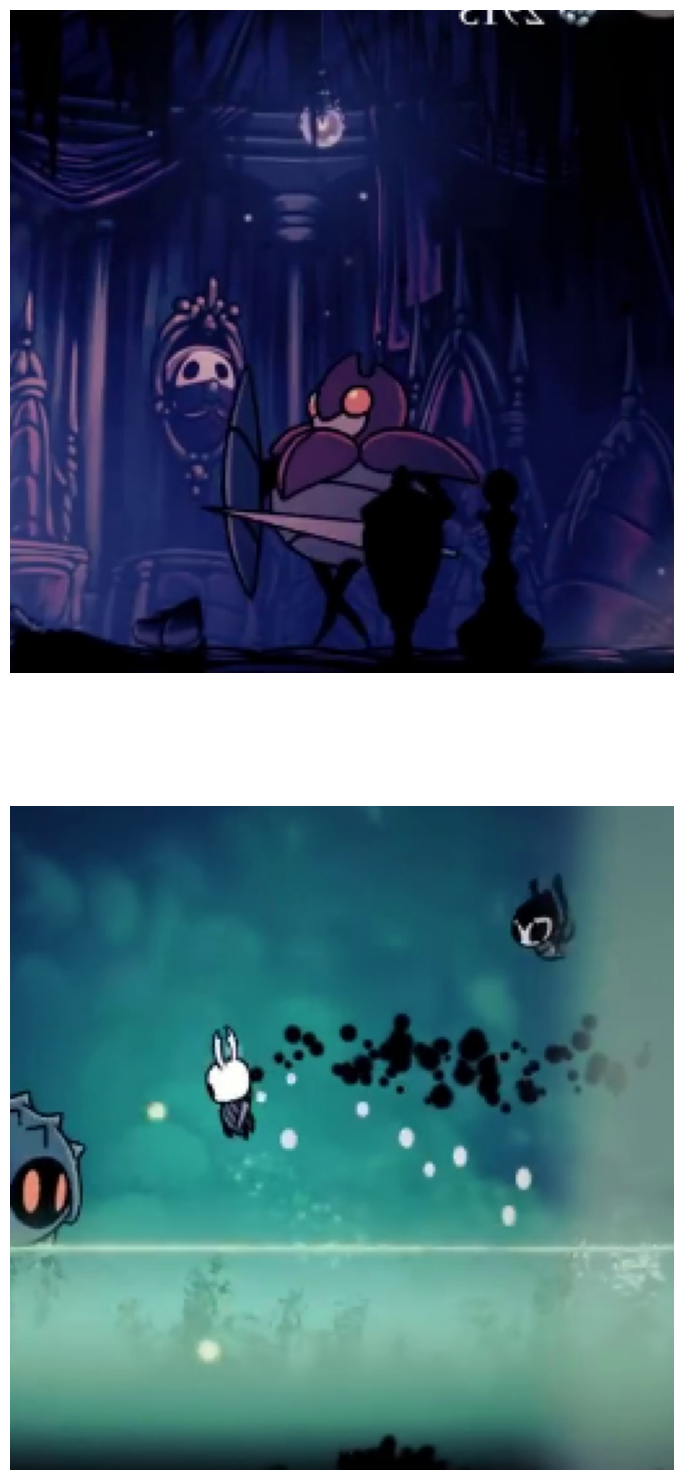

In [3]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
for i, image in enumerate(images[0][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(decenter_img(image))
    plt.axis("off")

train_ds.reset()

In [4]:
from keras import backend as K, losses
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from keras.models import Model, Sequential


def ssim_loss(y_true, y_pred):
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(decenter_img(y_true), decenter_img(y_pred), 1.0, filter_size=3))


def create_improved_baseline_model_12x_comp(image_size):
    ### Encoder ###

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_size[0], image_size[1], 3)))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))


    ### Decoder ###

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='tanh', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model


In [5]:
autoencoder = create_improved_baseline_model_12x_comp(crop_size)
autoencoder.summary()

('shape of encoded', (None, 16, 16, 32))
('shape of decoded', (None, 256, 256, 3))
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      2368      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                       

In [6]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0025), loss=ssim_loss)

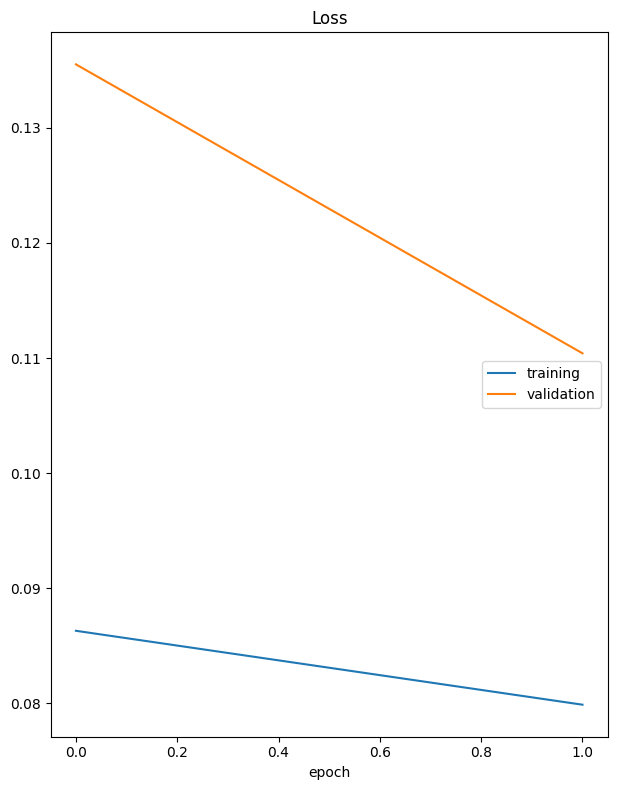

Loss
	training         	 (min:    0.080, max:    0.086, cur:    0.080)
	validation       	 (min:    0.110, max:    0.136, cur:    0.110)
106/106 [==============================] - 148s 1s/step - loss: 0.0799 - val_loss: 0.1104
Epoch 3/55
 50/106 [=============>................] - ETA: 1:10 - loss: 0.0754

KeyboardInterrupt: 

In [10]:
from keras.callbacks import CSVLogger
from livelossplot import PlotLossesKerasTF # Use version 0.5+, https://github.com/stared/livelossplot/

# Set APPEND=TRUE if you are continuing the training, so that the log.csv wouldn't be reset!
csv_logger = CSVLogger('log.csv', append=False, separator=';') # liveplotloss removes keras' log on the standard output. This will save it to 'log.csv'.
plot_logger = PlotLossesKerasTF()

autoencoder.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=55,
                callbacks=[csv_logger, plot_logger],
                verbose=1)


In [17]:
# Saving the model:
# autoencoder.save('../model-saves/improved-12x-RGB-v2/')

In [18]:
# Loading the model
# autoencoder = keras.models.load_model('../model-saves/improved-12x-RGB-v2/', custom_objects={
#     'ssim_loss': ssim_loss
# })

# autoencoder.summary()

1/1 [==============================] - 0s 58ms/step


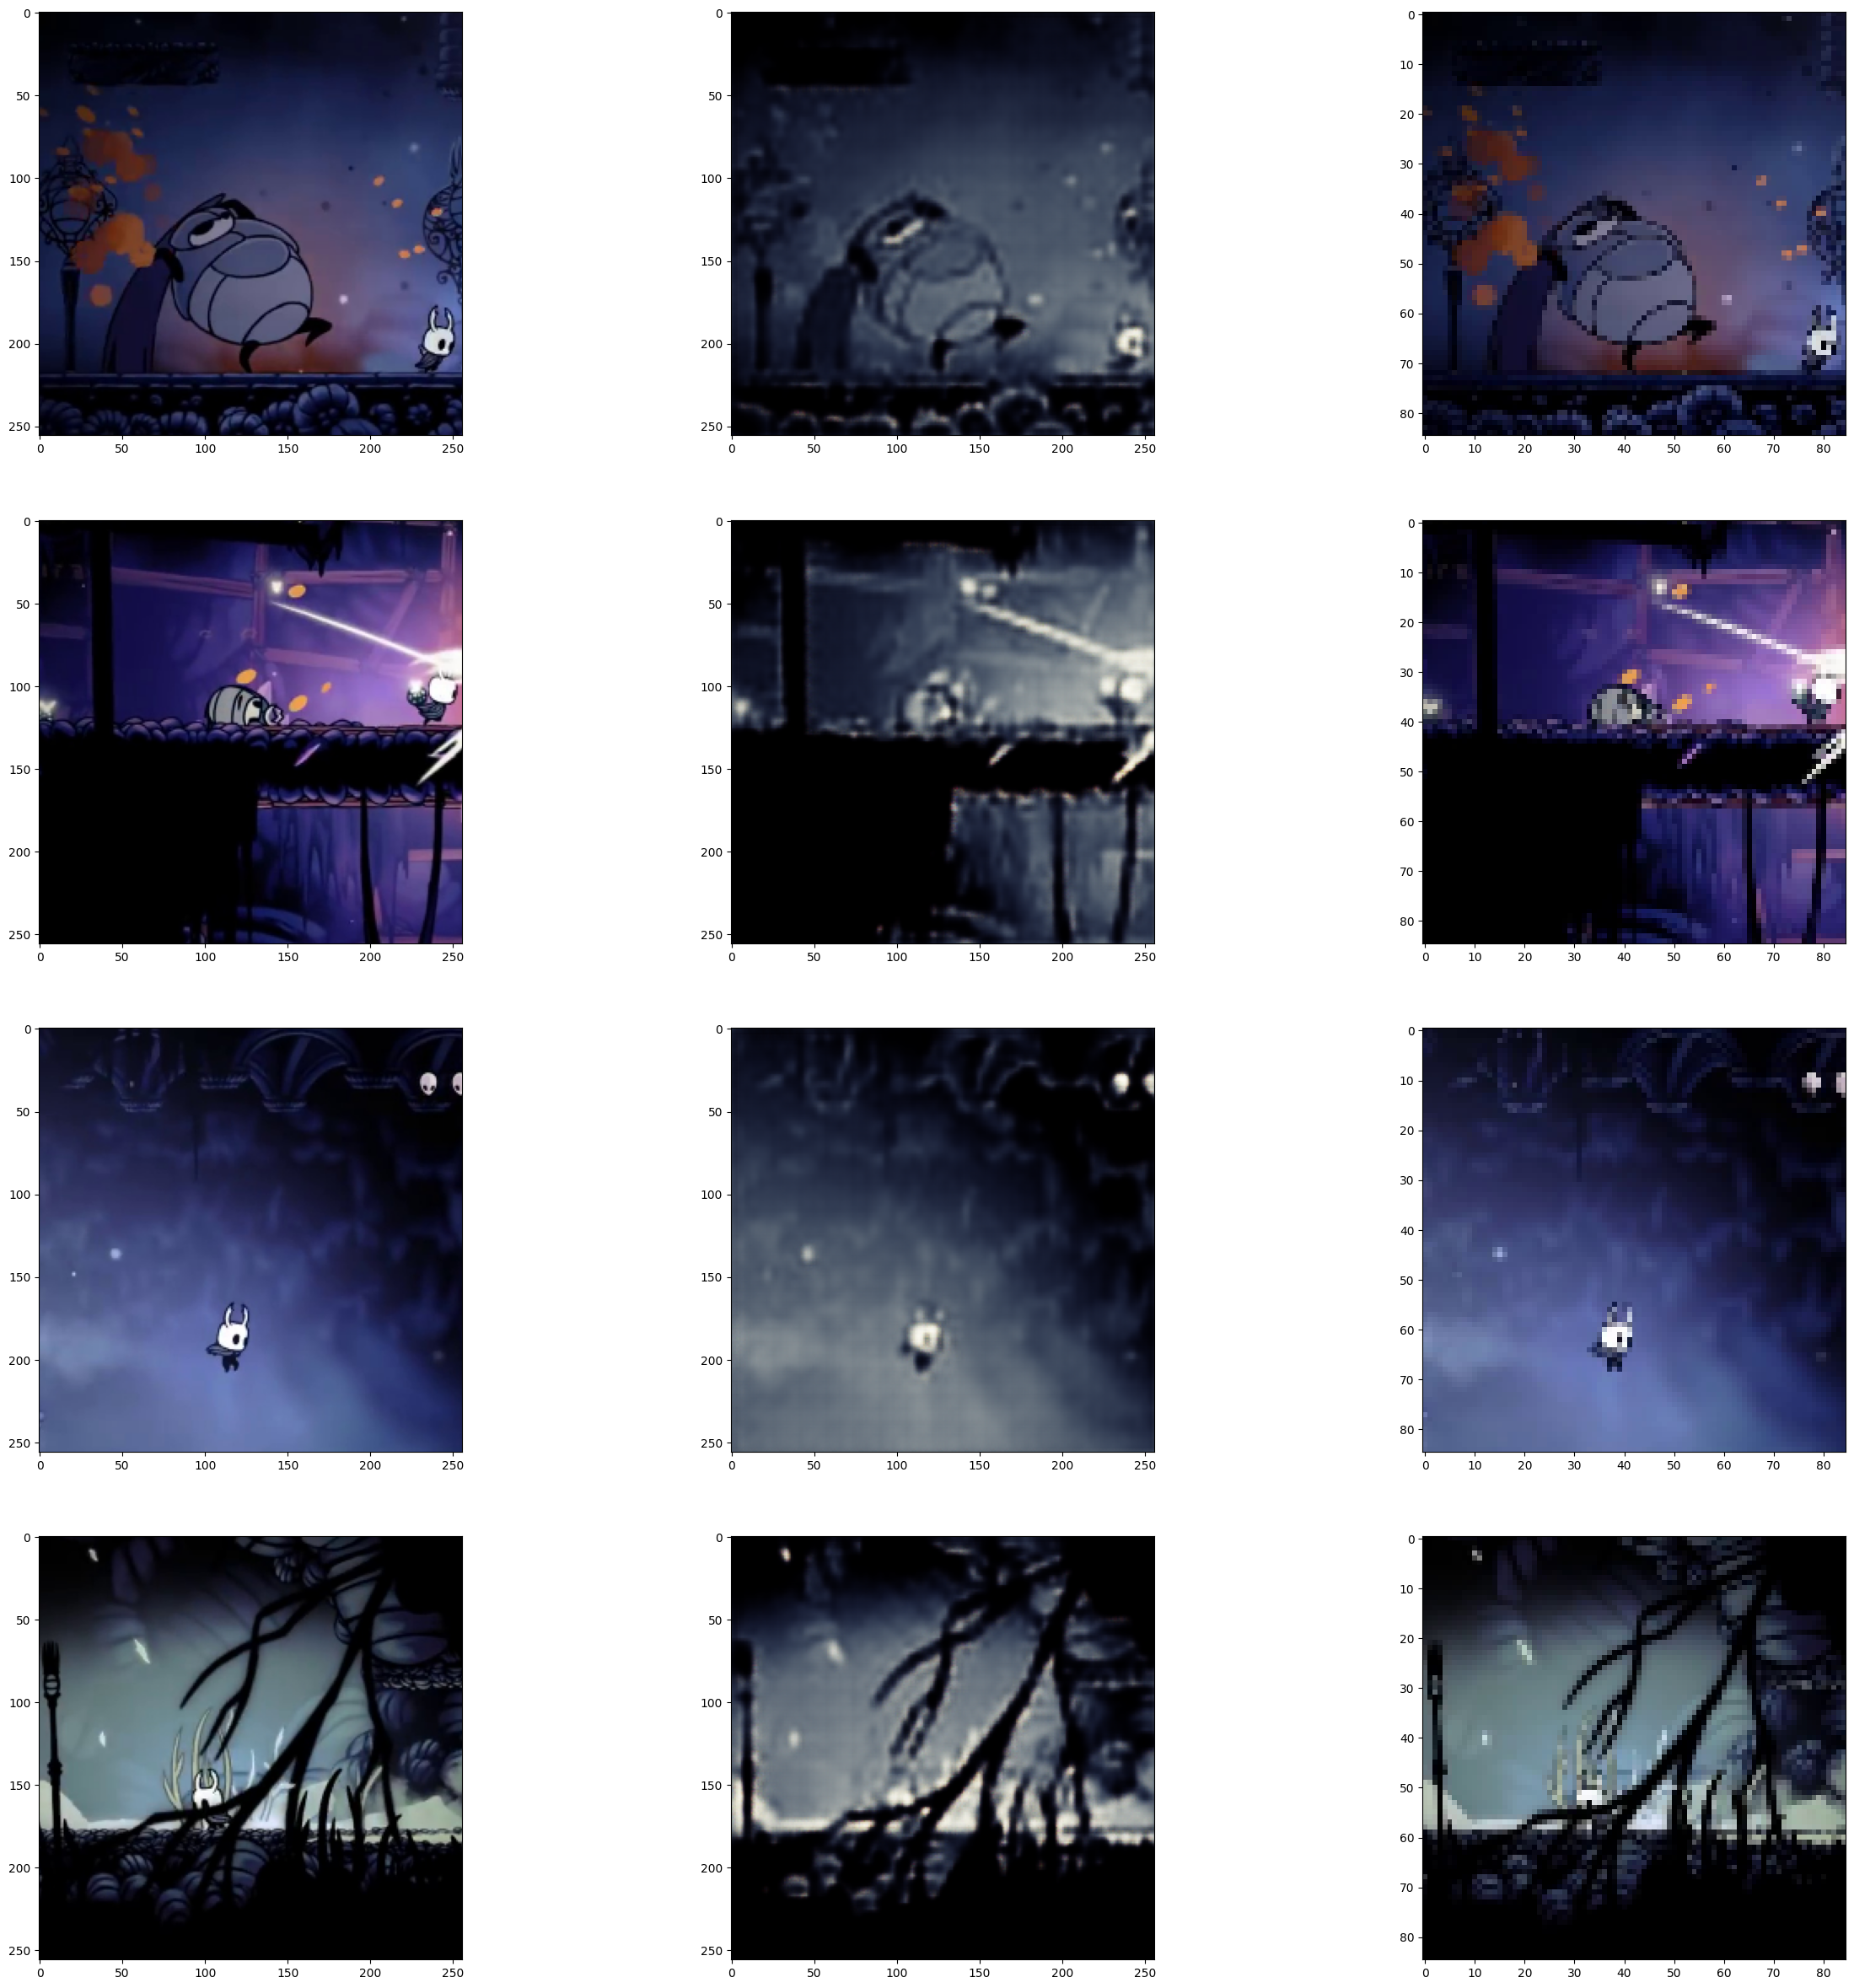

In [11]:
from matplotlib.pyplot import axes
import numpy as np

img_number = 4
test_images = next(test_ds_prep)[0][:img_number]
decoded_imgs = autoencoder.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(decenter_img(in_img))
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(decenter_img(out_img))
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(decenter_img(in_img), (in_img.shape[0] // 3, in_img.shape[1] // 3))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')